# Глава 3 - Классификация


Будем использовать набор MNIST содержащий 70000 изображений, написанными от руки.


In [1]:
import warnings; warnings.simplefilter('ignore')

from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Посмотрим на пример изображения


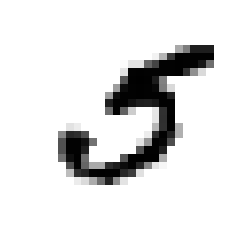

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
y[36000]

5.0

Разделим надоб данных на обучающий и тестовый. Данный надор разделен заранее.


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Перетасуем обучающий набор для перекрестной проверки


In [8]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Обучение двоичного классификатора

Обучим классификатор для определения одной цифры - 5. Будем определять "5" или не "5".

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Классификатор на основе стохастического градиентного спуска (SGD).

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
sgd_clf.predict([X[36000]])

array([ True])

## Оценка классификатора
### Оценка правильности с использованием перекрестной проверки


In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.9671 , 0.95865, 0.92785])

Правильность (accurecy) для всех трех выборок больше 95%. Но если пятерок в выборке всего около 10%,
то любой классификатор, который просто считает все не пятерками даст точность около 90%!
Поэтому данный метод для оценки классификаторов применяется редко.

### Матрица неточностей

Определяется сколько раз класс **A_** был отнесен к классу **В_** и тд.

В первуюочередь надо сделать набор оценок, чтобы сравнивать их с фактическими данными. Воспользуемся cross_val_predict(), которая вместо оценок возвращает прогнозы по каждому испытательному блоку. 

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53120,  1459],
       [ 1469,  3952]], dtype=int64)

Каждая строка представляет фактический класс, а каждый столбец спрогнозированный класс. Первая строка учитывает изображения не пятерок (отрицательный класс) - первый столбец корректно классифицированы как не пятерки (*true negative - TN*), второй столбец неправильно классифицированы как пятерки (*false positive - FP*). Вторая строка учитывает изображения пятерок, первый столбец ошибочно классифицированы как не пятерки (*false negative - FN*), вторая цифра  - корректно классифицированы (*true positive - TP*). 

Иногда можно упростить метрику - **точность** - *аккуратность положительных классификаций* (precision).
$$точноть = {TP \over TP + FP}$$

Вместе с **точностью** используется еще одна метрика **полнота** (recall), иногда называется *чувствительностью* или *долей истинно положительных классификаций (TRP)*.

$$
TRP = {TP \over TP + FN}
$$

In [17]:
from sklearn.metrics import precision_score, recall_score

print('Precision: ', precision_score(y_train_5, y_train_pred))
print('Recall :', recall_score(y_train_5, y_train_pred))

Precision:  0.7303640731842543
Recall : 0.7290167865707434


Precision показывает на сколько корректны предсказания классификатора, и обнаруживает он только Recall пятерок.

Точность и полноту объединяют в единственную метрику **мера F1**. Мера F1 - среднее гармоническое точности и полноты. 

$$F1 = {TP \over TP + {FN + FP \over 2}}$$


In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7296898079763664

Обычно при обучении классификатора соблюдается баланс точности и полноты (precision/recall tradeoff).


SGDCClassifier принимает решение на основе функции решения, которая вычесляет сумму очков для каждого образца. Если сумма больше порогового значения - положительное решение, иначе отрицательное. Нельзя установить порог напрямую. Но можно посмотретьсуммы очков для каждого образца.


In [19]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Поднятие порога снижает полноту, "5" сейчас определяется как не пятерка. 
Получим суммы очков всех образцов в обучающем наборе и вычислим точноть и полноту как функцию порога:

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

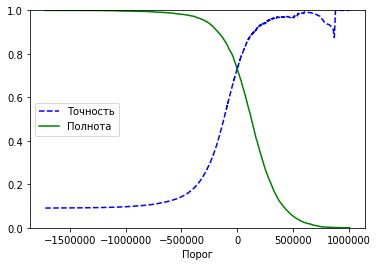

In [21]:
def plot_precisions_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Точность")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Полнота")
    plt.xlabel("Порог")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precisions_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

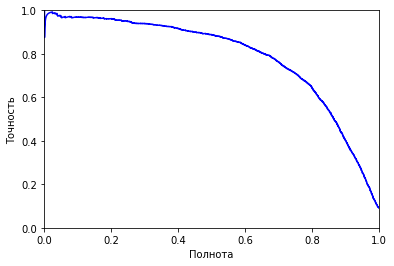

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Полнота")
    plt.ylabel("Точность")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

Можно выбрать порог, который будет соответствовать необходимой точности. Например для 90% необходим примерно 70000 порог. Для выработки прогнозов:

In [23]:
y_train_pred_90 = (y_scores > 60000)

print("Точность:", precision_score(y_train_5, y_train_pred_90))
print("Полнота:", recall_score(y_train_5, y_train_pred_90))

Точность: 0.8197507190795782
Полнота: 0.630879911455451


**Рабочая характеристика приемника (ROC)** - похожа на кривую точность-полнота, но изображает *долю истинно положительных классификаций* по отношению к *доле ложноположительных классификаций (FPR)*. Доля FPR это пропорция отрицательных образов, которые были классифицированы как положительные. FPR = 1 - TNR. TNR - пропорция отрицательных образов, которые классифицированы как отрицательные.

**Доля TNR** - специфичность. Кривая ROC изображает *чувствительность* в сравнении с *1-спецефичность*.

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

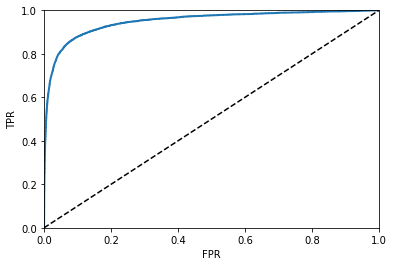

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plot_roc_curve(fpr, tpr, thresholds)
plt.show()

Пунктир кривая ROC для чисто случайного классификатора, хороший классификатор должен максимально отстоять от этой кривой в левый верхний угол.

Сравнение классификаторов проводят по площади под кривой ROC - AUC ROC. Безупречный классификатор будет иметь площать 1, а случайный 0.5

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9497412433295355

### Сравним классификаторы RandomForestClassifier и SGDClassifier.

Необходимо получить показатели для каждого образца.
RandomForestClassifier - нет метода decision_function(). predict_proba() - метод взамен, возвращает массив, который содержит строку на образец и строку на класс, с вероятность того, что заданный образец принадлежит заданному классу.

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

Возьмем в качестве показателя вероятность положительного класса

In [28]:
y_scores_forest = y_probas_forest[:, 1]

In [29]:
fpr_forest, tpr_forest, threshholds_forest = roc_curve(y_train_5, y_scores_forest)

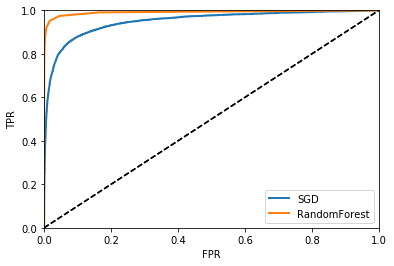

In [30]:
plot_roc_curve(fpr, tpr, 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForest')
plt.legend(loc='lower right')
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9913415601062483

In [32]:
y_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print("Точность:", precision_score(y_train_5, y_forest))
print("Полнота:", recall_score(y_train_5, y_forest))

Точность: 0.9843232501655995
Полнота: 0.8223574986164914


## Многоклассовая классификация

**OvA** - "один против всех" - обучается нужное количество двоичных классификаторов, потом через них прогоняется изображение, чей балл выше, тот классификатор и побеждает.
**OvO** - "один против одного" - обучение двоичных классификаторов для каждой пары значений. Потом изображение прогоняется через все классификаторы и посмотреть какой класс выиграл больше всех дуэлей. Преимущество - обучение проходит на части набора данных.

scikit-learn - автоматически определяет многоклассовую классификацию и применяет стратегию OvA.


In [33]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [34]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-305261.79672968, -476579.68000048, -499218.06429223,
        -162635.01736232, -342778.08718351,   80187.69407936,
        -765572.66691238, -382545.6590674 , -654868.34245849,
        -808408.14693217]])

In [35]:
np.argmax(some_digit_scores)

5

In [36]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

Изменить стратегию можно с помощью OneVsOneClassifier

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [39]:
len(ovo_clf.estimators_)

45

RandomForestClassifier обучается также легко, данный классификатор спосеб группировать образы напрямую в множество классов.

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

Показано распределения вероятностей отнесения изображения к каждому классу

In [41]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0.1]])

Проведем перекрестную проверку классификатора:

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring='accuracy')

array([0.88867227, 0.86724336, 0.79361904])

Масштабирование входных данных позволяет еще улучшить точность прогнозов:

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring='accuracy')

array([0.91086783, 0.91124556, 0.90783618])

## Анализ ошибок

Первым делом построим матрицу неточностей

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_m = confusion_matrix(y_train, y_train_pred)

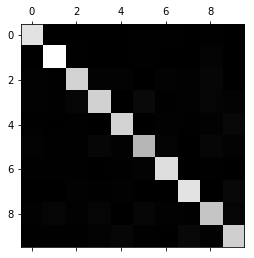

In [45]:
plt.matshow(conf_m, cmap = plt.cm.gray)
plt.show()

Опеределим число изображений в каждом классе. Будем сранвивать частоту ошибок, а не их абсолютное количество.

In [46]:
row_sums = conf_m.sum(axis = 1, keepdims = True)
norm_conf_m = conf_m / row_sums

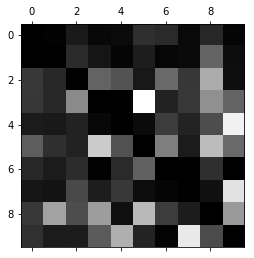

In [49]:
np.fill_diagonal(norm_conf_m, 0)
plt.matshow(norm_conf_m, cmap = plt.cm.gray)
plt.show()

Светлые участки показывают больше ошибок, темные - правильные классификации.

## Многозначная классификация

Иногда нужно выдать несколько классов для образца. Сделаем две целевые метки - является ли цифра больше 7 и четная или нет. Применим классификатор, который поддерживает многозначную классификацию.

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [51]:
knn_clf.predict([some_digit])

array([[False,  True]])

Способы оценки есть разные, например посчитать F1 и потом взять среднюю сумму очков. Если метки не равнозначные, то можно ввести веса - average = "weighted".

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs = 3)

In [56]:
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.9768896720709622

## Упражнения

### 1

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
knn = KNeighborsClassifier()

parameters = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [4, 5, 10],
}

knn_clf = GridSearchCV(knn, parameters, cv = 5, n_jobs = 3)

In [ ]:
knn_clf.fit(X_train, y_train)

In [ ]:
knn_clf.best_estimator_

In [ ]:
%%time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

y_knn = cross_val_predict(knn_clf, X_train, y_train, cv=3, verbose=5)

print("Точность:", precision_score(y_train, y_knn))
print("Полнота:", recall_score(y_train, y_knn))